In [1]:
import numpy as np
import scipy as sp
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import numpy.random as rnd
rnd.seed(42)

from collections import namedtuple

from operator import itemgetter
from itertools import accumulate, chain
from functools import reduce

# Utils

In [2]:
def random_walk(size, mean=0, sd=1, start=0):
    sample = np.cumsum(rnd.normal(loc=mean, scale=sd, size=size))
    return pd.Series(sample + start - sample[0])
    
def slopes(limit, apfreq, mean=0, sd=1):
    counts = np.ceil(rnd.exponential(size=limit, scale=apfreq)).astype(np.int64)
    counts = counts[counts.cumsum() <= limit]
    counts = np.append(counts, limit - counts.sum())
    slopes = rnd.normal(size=len(counts), loc=mean, scale=sd)
    return pd.DataFrame({'count': counts, 'slope': slopes})
    
def piecewise_linear(slopes, start=0):
    series = np.zeros(slopes['count'].sum())
    offset = 0
    for index, row in slopes.iterrows():
        count = int(row['count'])
        series[offset:(count+offset)] = linear(size=int(count), a=row['slope'], b=series[offset-1], series=False)
        offset += count
    return pd.Series(series)    
    
def linear(size, a=1., b=0., series=True):
    arr = a * (np.arange(size) + 1) + b
    return pd.Series(arr) if series else arr

In [3]:
def filter_series(series, filt, drop_na=False):
    win_size = len(filt)
    res =  series.rolling(win_size).apply(lambda w: w.dot(filt), raw=False)
    return res.dropna() if drop_na else res

def diff_series(series, drop_na=False):
    filt = np.array([-1, 1])
    return filter_series(series, filt, drop_na)

# Описание модели

Мы рассмотрим ряд, который имеет следующую модель: $$x_t = x_{t-1} + a_t + \epsilon_t\,$$ где $a_t \sim \mathcal{N}(\mu, \sigma_1)$ --- скорость изменения линейного тренда, которая выбирается случайно из нормального распределения раз в $t \sim \mathcal{Exp}(\lambda)$, $\epsilon_t \sim \mathcal{N}(0, \sigma_2)$

Пусть у нас есть ряд длины $N$. Наша задача предсказать значение в $N+1$ точке. Заметим, что на промежутке с постоянным значением $a_t=a$ (не умаляя общности рассмотрим $t \in [0, T]$): $$x_t = x_0 + a \cdot t + \sum_{i=1}^{t}{\epsilon_i} = x_0 + a \cdot t + W_{t},$$ где $W_t$ --- винеровский процесс. Получается: $x_t - x_{t-1} = a + \epsilon_t,$ и возможно без труда найти оценку угла наклона, необходимо лишь определится с размером окна

In [52]:
Prediction = namedtuple('Prediction', ['Series', 'Prediction', 'Slope', 'Model'])

class SimpleLinearModel(object):
    def __init__(self, min_window=1, max_window=-1, window_step=1):
        self._window_step = window_step
        self._max_window = max_window
        self._min_window = min_window
        self._fitted_window = None
        self._window_scores = None
        
    @property
    def window_step(self):
        return self._window_step
    
    @window_step.setter
    def window_step(self, new_step):
        self._window_step = new_step
        
    @property
    def max_window(self):
        return self._max_window
    
    @max_window.setter
    def max_window(self, new_max):
        self._max_window = new_max
    
    @property
    def min_window(self):
        return self._min_window
    
    @min_window.setter
    def min_window(self, new_min):
        self._min_window = new_min
    
    @property
    def win_scores(self):
        return self._window_scores
    
    @property
    def fitted_window(self):
        return self._fitted_window
    
    @staticmethod
    def _gen_eval_window(length):
        filt = np.ones(length + 1)
        filt[0:length] /= -length
        return filt
    
    def fit(self, series):
        scores = []
        diff = diff_series(series, drop_na=True)
        
        max_window = self._max_window if self._max_window > 0 else len(diff) - 1
        for i in range(self._min_window, self._max_window, self._window_step):
            eval_filt = SimpleLinearModel._gen_eval_window(i)
            scores.append((i + 1, (filter_series(diff, eval_filt, drop_na=True) ** 2).mean()))
        
        self._window_scores = sorted(scores, key=itemgetter(1))
        self._fitted_window = self._window_scores[0][0]
        
        return self
        
    def predict(self, series, length):
        if len(series) < self._fitted_window:
            raise Exception(f"Length of a series must be at least {self._fitted_window} to make a prediction")
        
        slope = diff_series(series.tail(self._fitted_window)).mean()
        pred_idx = np.arange(length) + len(series)
        prediction = pd.Series(slope * (np.arange(length) + 1) + series[len(series) - 1], index=pred_idx)
        return Prediction(Prediction=prediction, Series=series, Slope=slope, Model=self)

In [5]:
def simple_predictor(series):
    return series.tail(1)

Как выглядит временно1 ряд и ранзности. Мы зададим небольшую дисперсию у случайных величин $\epsilon_i$, чтобы уменьшить влияние шума для демострации:

In [37]:
dem_sl = slopes(1000, 200, mean=0, sd=1)
dem_ln = piecewise_linear(sl)
dem_rw = random_walk(1000, sd=0.3)
dem_series = dem_ln + dem_rw

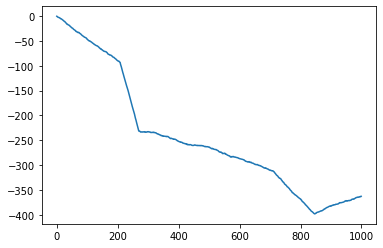

In [38]:
plt.plot(dem_series)

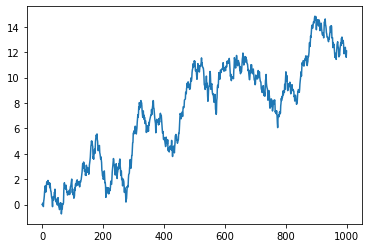

In [39]:
plt.plot(dem_rw)

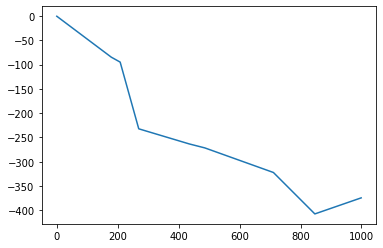

In [40]:
plt.plot(dem_ln)

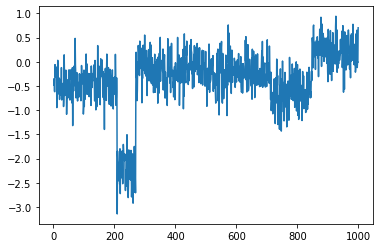

In [41]:
plt.plot(diff_series(dem_series, drop_na=True))

Размеется, определение коэффициента наклона для такого ряда задача несложная: шум не перекрывает тренд ряда. Для экспериментов мы увеличим дисперсию шума: 

In [44]:
sl = slopes(1000, 200, sd=0.1)
ln = piecewise_linear(sl)
rw = random_walk(1000, sd=1)
series = ln + rw

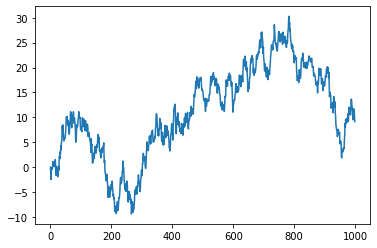

In [45]:
plt.plot(series)

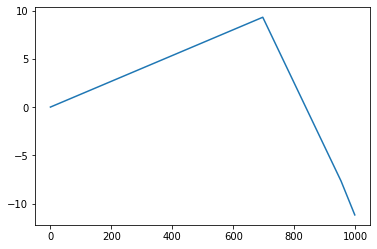

In [47]:
plt.plot(ln)

In [53]:
model = SimpleLinearModel(min_window=1, max_window=500, window_step=10)
model = model.fit(series)

In [54]:
model.fitted_window

482

In [55]:
pred = model.predict(series, 10)

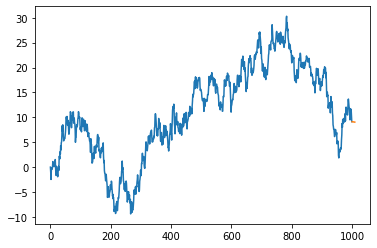

In [56]:
plt.plot(series)
plt.plot(pred.Prediction)

In [57]:
pred.Slope

-0.009135309980393691